In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# RVs with multiple instruments

In this case study, we will look at how we can use exoplanet and PyMC3 to combine datasets from different RV instruments to fit the orbit of an exoplanet system.
Before getting started, I want to emphasize that the exoplanet code doesn't have strong opinions about how your data are collected, it only provides extensions that allow PyMC3 to evaluate some astronomy-specific functions.
This means that you can build any kind of observation model that PyMC3 supports, and support for multiple instruments isn't really a *feature* of exoplanet, even though it is easy to implement.

For the example, we'll use public observations of Pi Mensae which hosts two planets, but we'll ignore the inner planet because the significance of the RV signal is small enough that it won't affect our results.
The datasets that we'll use are from the Anglo-Australian Planet Search (AAT) and the HARPS archive.
As is commonly done, we will treat the HARPS observations as two independent datasets split in June 2015 when the HARPS hardware was upgraded.
Therefore, we'll consider three datasets that we will allow to have different instrumental parameters (RV offset and jitter), but shared orbital parameters and stellar variability.
In some cases you might also want to have a different astrophyscial variability model for each instrument (if, for example, the observations are made in very different bands), but we'll keep things simple for this example.

The AAT data are available from [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) and the HARPS observations can be downloaded from the [ESO Archive](http://archive.eso.org/wdb/wdb/adp/phase3_spectral/form).
For the sake of simplicity, we have extracted the HARPS RVs from the archive in advance using [Megan Bedell's harps_tools library](https://github.com/megbedell/harps_tools).

To start, download the data and plot them with a (very!) rough zero point correction.

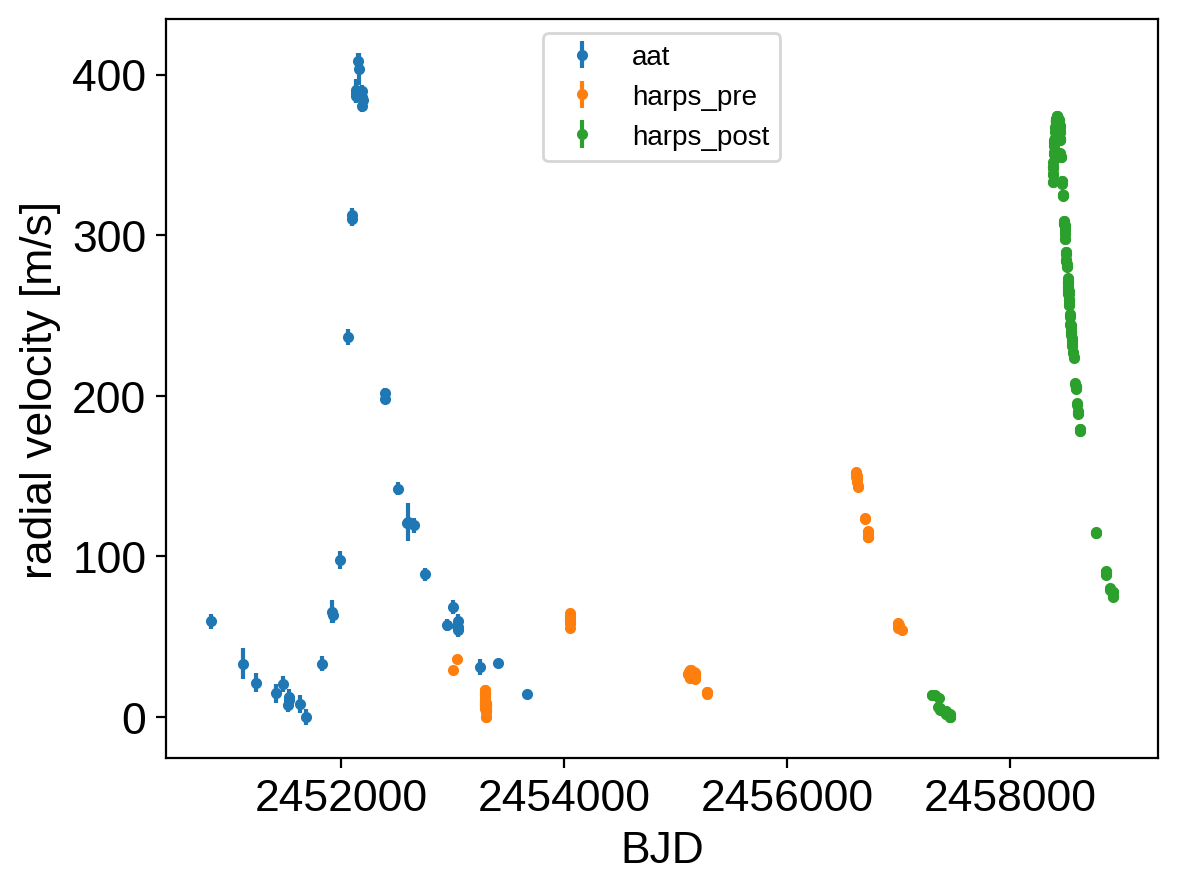

In [3]:
import numpy as np
import pandas as pd
from astropy.io import ascii

aat = ascii.read(
    "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0026/0026394/data/UID_0026394_RVC_001.tbl"
)
harps = pd.read_csv(
    "https://raw.githubusercontent.com/exoplanet-dev/case-studies/master/data/pi_men_harps_rvs.csv",
    skiprows=1,
)
harps = harps.rename(lambda x: x.strip().strip("#"), axis=1)
harps_post = np.array(harps.date > "2015-07-01", dtype=int)

t = np.concatenate((aat["JD"], harps["bjd"]))
rv = np.concatenate((aat["Radial_Velocity"], harps["rv"]))
rv_err = np.concatenate((aat["Radial_Velocity_Uncertainty"], harps["e_rv"]))
inst_id = np.concatenate((np.zeros(len(aat), dtype=int), harps_post + 1))

inds = np.argsort(t)
t = np.ascontiguousarray(t[inds], dtype=float)
rv = np.ascontiguousarray(rv[inds], dtype=float)
rv_err = np.ascontiguousarray(rv_err[inds], dtype=float)
inst_id = np.ascontiguousarray(inst_id[inds], dtype=int)

inst_names = ["aat", "harps_pre", "harps_post"]
num_inst = len(inst_names)

for i, name in enumerate(inst_names):
    m = inst_id == i
    plt.errorbar(t[m], rv[m] - np.min(rv[m]), yerr=rv_err[m], fmt=".", label=name)

plt.legend(fontsize=10)
plt.xlabel("BJD")
_ = plt.ylabel("radial velocity [m/s]")

Then set up the probabilistic model.
Most of this is similar to the model in the :ref:`rv` tutorial, but there are a few changes to highlight:

1. Instead of a polynomial model for trends, stellar varaiability, and inner planets, we're using a Gaussian process here. This won't have a big effect here, but more careful consideration should be performed when studying lower signal-to-noise systems.
2. There are three radial velocity offests and three jitter parameters (one for each instrument) that will be treated independently. This is the key addition made by this case study.

In [4]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

with pm.Model() as model:

    # Parameters describing the orbit
    K = pm.Lognormal("K", mu=np.log(300), sigma=10)
    P = pm.Lognormal("P", mu=np.log(2093.07), sigma=10)

    ecs = xo.UnitDisk("ecs", testval=np.array([0.7, -0.3]))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    phase = xo.UnitUniform("phase")
    tp = pm.Deterministic("tp", 0.5 * (t.min() + t.max()) + phase * P)

    orbit = xo.orbits.KeplerianOrbit(period=P, t_periastron=tp, ecc=ecc, omega=omega)

    # Noise model parameters
    S_tot = pm.Lognormal("S_tot", mu=np.log(10), sigma=50)
    ell = pm.Lognormal("ell", mu=np.log(50), sigma=50)

    # Per instrument parameters
    means = pm.Normal(
        "means",
        mu=np.array([np.median(rv[inst_id == i]) for i in range(num_inst)]),
        sigma=200,
        shape=num_inst,
    )
    sigmas = pm.HalfNormal("sigmas", sigma=10, shape=num_inst)

    # Compute the RV offset and jitter for each data point depending on its instrument
    mean = tt.zeros(len(t))
    diag = tt.zeros(len(t))
    for i in range(len(inst_names)):
        mean += means[i] * (inst_id == i)
        diag += (rv_err ** 2 + sigmas[i] ** 2) * (inst_id == i)
    pm.Deterministic("mean", mean)
    pm.Deterministic("diag", diag)

    def rv_model(x):
        return orbit.get_radial_velocity(x, K=K)

    kernel = xo.gp.terms.SHOTerm(S_tot=S_tot, w0=2 * np.pi / ell, Q=1.0 / 3)
    gp = xo.gp.GP(kernel, t, diag, mean=rv_model)
    gp.marginal("obs", observed=rv - mean)
    pm.Deterministic("gp_pred", gp.predict())

    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [means])
    map_soln = xo.optimize(map_soln, [means, phase])
    map_soln = xo.optimize(map_soln, [means, phase, K])
    map_soln = xo.optimize(map_soln, [means, tp, K, P, ecs])
    map_soln = xo.optimize(map_soln, [sigmas, S_tot, ell])
    map_soln = xo.optimize(map_soln)

optimizing logp for variables: [means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.809431e+04]

1it [00:00, 182.27it/s, logp=-1.809431e+04]

2it [00:00, 263.36it/s, logp=-1.809431e+04]

3it [00:00, 289.02it/s, logp=-1.800406e+04]

4it [00:00, 329.12it/s, logp=-1.764945e+04]

5it [00:00, 363.21it/s, logp=-1.633369e+04]

6it [00:00, 373.00it/s, logp=-1.342429e+04]

7it [00:00, 392.33it/s, logp=-1.139325e+04]

8it [00:00, 402.91it/s, logp=-1.137849e+04]

9it [00:00, 421.45it/s, logp=-1.137149e+04]

10it [00:00, 437.81it/s, logp=-1.137138e+04]

11it [00:00, 458.72it/s, logp=-1.137136e+04]

12it [00:00, 469.98it/s, logp=-1.137136e+04]

13it [00:00, 481.69it/s, logp=-1.137136e+04]

14it [00:08,  1.59it/s, logp=-1.137136e+04] 


message: Optimization terminated successfully.
logp: -18094.31463741889 -> -11371.356631997516


optimizing logp for variables: [phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.137136e+04]

1it [00:00, 241.62it/s, logp=-1.137136e+04]

2it [00:00, 325.77it/s, logp=-1.137136e+04]

3it [00:00, 345.26it/s, logp=-3.346436e+04]

4it [00:00, 375.13it/s, logp=-1.129164e+04]

5it [00:00, 377.29it/s, logp=-1.124248e+04]

6it [00:00, 385.33it/s, logp=-1.123985e+04]

7it [00:00, 391.66it/s, logp=-1.123949e+04]

8it [00:00, 396.60it/s, logp=-1.123947e+04]

9it [00:00, 404.79it/s, logp=-1.123947e+04]

10it [00:00, 412.33it/s, logp=-1.123946e+04]

11it [00:00, 419.83it/s, logp=-1.123946e+04]

12it [00:00, 426.03it/s, logp=-1.123946e+04]

13it [00:00, 433.56it/s, logp=-1.123946e+04]

14it [00:00, 431.30it/s, logp=-1.123946e+04]

15it [00:00, 431.48it/s, logp=-1.123946e+04]

16it [00:00, 432.39it/s, logp=-1.123946e+04]

17it [00:00, 438.38it/s, logp=-1.123946e+04]

18it [00:00, 444.07it/s, logp=-1.123946e+04]

19it [00:00, 454.48it/s, logp=-1.123946e+04]

20it [00:00, 463.73it/s, logp=-1.123946e+04]

21it [00:00, 472.51it/s, logp=-1.123946e+04]

22it [00:00, 482.14it/s, logp=-1.123946e+04]

23it [00:00, 491.19it/s, logp=-1.123946e+04]

24it [00:00, 497.86it/s, logp=-1.123946e+04]

25it [00:00, 500.81it/s, logp=-1.123946e+04]

26it [00:00, 510.81it/s, logp=-1.123946e+04]

27it [00:00, 519.52it/s, logp=-1.123946e+04]

28it [00:00, 527.91it/s, logp=-1.123946e+04]

29it [00:00, 537.21it/s, logp=-1.123946e+04]

30it [00:00, 546.02it/s, logp=-1.123946e+04]

31it [00:00, 555.09it/s, logp=-1.123946e+04]

32it [00:00, 563.86it/s, logp=-1.123946e+04]

33it [00:00, 571.96it/s, logp=-1.123946e+04]

34it [00:00, 580.03it/s, logp=-1.123946e+04]

35it [00:00, 587.82it/s, logp=-1.123946e+04]

36it [00:00, 595.30it/s, logp=-1.123946e+04]

37it [00:00, 588.76it/s, logp=-1.123946e+04]

38it [00:00, 595.39it/s, logp=-1.123946e+04]

39it [00:00, 602.55it/s, logp=-1.123946e+04]

40it [00:00, 608.88it/s, logp=-1.123946e+04]

41it [00:00, 614.90it/s, logp=-1.123946e+04]

42it [00:00, 621.00it/s, logp=-1.123946e+04]

43it [00:00, 626.85it/s, logp=-1.123946e+04]

44it [00:00, 623.23it/s, logp=-1.123946e+04]

45it [00:00, 620.33it/s, logp=-1.123946e+04]

46it [00:00, 602.58it/s, logp=-1.123946e+04]

47it [00:00, 598.62it/s, logp=-1.123946e+04]

48it [00:00, 595.30it/s, logp=-1.123946e+04]

49it [00:00, 593.29it/s, logp=-1.123946e+04]

50it [00:00, 591.67it/s, logp=-1.123946e+04]

51it [00:00, 590.16it/s, logp=-1.123946e+04]

52it [00:00, 588.70it/s, logp=-1.123946e+04]

53it [00:00, 587.29it/s, logp=-1.123946e+04]

54it [00:00, 586.27it/s, logp=-1.123946e+04]

55it [00:00, 586.26it/s, logp=-1.123946e+04]

56it [00:00, 585.99it/s, logp=-1.123946e+04]

57it [00:00, 585.57it/s, logp=-1.123946e+04]

58it [00:00, 585.18it/s, logp=-1.123946e+04]

59it [00:00, 584.80it/s, logp=-1.123946e+04]

60it [00:00, 590.71it/s, logp=-1.123946e+04]

60it [00:00, 590.71it/s, logp=-1.123946e+04]

61it [00:00, 590.71it/s, logp=-1.123946e+04]

62it [00:00, 590.71it/s, logp=-1.123946e+04]

63it [00:00, 590.71it/s, logp=-1.123946e+04]

64it [00:00, 590.71it/s, logp=-1.123946e+04]

65it [00:00, 590.71it/s, logp=-1.123946e+04]

66it [00:00, 590.71it/s, logp=-1.123946e+04]

67it [00:00, 590.71it/s, logp=-1.123946e+04]

68it [00:00, 590.71it/s, logp=-1.123946e+04]

69it [00:00, 590.71it/s, logp=-1.123946e+04]

70it [00:00, 590.71it/s, logp=-1.123946e+04]

71it [00:00, 590.71it/s, logp=-1.123946e+04]

72it [00:00, 590.71it/s, logp=-1.123946e+04]

73it [00:00, 590.71it/s, logp=-1.123946e+04]

74it [00:00, 590.71it/s, logp=-1.123946e+04]

75it [00:00, 590.71it/s, logp=-1.123946e+04]

76it [00:00, 590.71it/s, logp=-1.123946e+04]

77it [00:00, 590.71it/s, logp=-1.123946e+04]

78it [00:00, 590.71it/s, logp=-1.123946e+04]

79it [00:00, 590.71it/s, logp=-1.123946e+04]

80it [00:00, 590.71it/s, logp=-1.123946e+04]

81it [00:00, 590.71it/s, logp=-1.123946e+04]

82it [00:00, 590.71it/s, logp=-1.123946e+04]

83it [00:00, 590.71it/s, logp=-1.123946e+04]

84it [00:00, 590.71it/s, logp=-1.123946e+04]

85it [00:00, 590.71it/s, logp=-1.123946e+04]

86it [00:00, 590.71it/s, logp=-1.123946e+04]

87it [00:00, 590.71it/s, logp=-1.123946e+04]

88it [00:00, 590.71it/s, logp=-1.123946e+04]

89it [00:00, 590.71it/s, logp=-1.123946e+04]

90it [00:00, 590.71it/s, logp=-1.123946e+04]

91it [00:00, 590.71it/s, logp=-1.123946e+04]

92it [00:00, 590.71it/s, logp=-1.123946e+04]

93it [00:00, 590.71it/s, logp=-1.123946e+04]

94it [00:00, 590.71it/s, logp=-1.123946e+04]

95it [00:00, 590.71it/s, logp=-1.123946e+04]

96it [00:00, 590.71it/s, logp=-1.123946e+04]

97it [00:00, 590.71it/s, logp=-1.123946e+04]

98it [00:00, 590.71it/s, logp=-1.123946e+04]

99it [00:00, 590.71it/s, logp=-1.123946e+04]

100it [00:00, 590.71it/s, logp=-1.123946e+04]

101it [00:00, 590.71it/s, logp=-1.123946e+04]

102it [00:00, 590.71it/s, logp=-1.123946e+04]

103it [00:00, 590.71it/s, logp=-1.123946e+04]

104it [00:00, 590.71it/s, logp=-1.123946e+04]

105it [00:00, 590.71it/s, logp=-1.123946e+04]

106it [00:00, 590.71it/s, logp=-1.123946e+04]

107it [00:00, 590.71it/s, logp=-1.123946e+04]

108it [00:00, 590.71it/s, logp=-1.123946e+04]

109it [00:00, 590.71it/s, logp=-1.123946e+04]

110it [00:00, 590.71it/s, logp=-1.123946e+04]

111it [00:00, 561.59it/s, logp=-1.123946e+04]

111it [00:00, 561.59it/s, logp=-1.123946e+04]

112it [00:00, 561.59it/s, logp=-1.123946e+04]

113it [00:00, 561.59it/s, logp=-1.123946e+04]

114it [00:00, 561.59it/s, logp=-1.123946e+04]

115it [00:00, 561.59it/s, logp=-1.123946e+04]

116it [00:00, 561.59it/s, logp=-1.123946e+04]

117it [00:00, 561.59it/s, logp=-1.123946e+04]

118it [00:00, 561.59it/s, logp=-1.123946e+04]

119it [00:00, 561.59it/s, logp=-1.123946e+04]

120it [00:00, 561.59it/s, logp=-1.123946e+04]

121it [00:00, 561.59it/s, logp=-1.123946e+04]

122it [00:00, 561.59it/s, logp=-1.123946e+04]

123it [00:00, 561.59it/s, logp=-1.123946e+04]

124it [00:00, 561.59it/s, logp=-1.123946e+04]

125it [00:00, 561.59it/s, logp=-1.123946e+04]

126it [00:00, 561.59it/s, logp=-1.123946e+04]

127it [00:00, 561.59it/s, logp=-1.123946e+04]

128it [00:00, 561.59it/s, logp=-1.123946e+04]

129it [00:00, 561.59it/s, logp=-1.123946e+04]

130it [00:00, 561.59it/s, logp=-1.123946e+04]

131it [00:00, 561.59it/s, logp=-1.123946e+04]

132it [00:00, 561.59it/s, logp=-1.123946e+04]

133it [00:00, 561.59it/s, logp=-1.123946e+04]

134it [00:00, 173.21it/s, logp=-1.123946e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -11371.356631997516 -> -11239.464875071475


optimizing logp for variables: [K, phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.123946e+04]

1it [00:00, 325.59it/s, logp=-1.123946e+04]

2it [00:00, 465.59it/s, logp=-1.123946e+04]

3it [00:00, 519.01it/s, logp=-1.074352e+04]

4it [00:00, 555.52it/s, logp=-9.979050e+03]

5it [00:00, 594.67it/s, logp=-1.679366e+04]

6it [00:00, 621.42it/s, logp=-8.506268e+03]

7it [00:00, 650.84it/s, logp=-8.419221e+03]

8it [00:00, 665.71it/s, logp=-1.623632e+04]

9it [00:00, 683.36it/s, logp=-8.371619e+03]

10it [00:00, 690.58it/s, logp=-8.275967e+03]

11it [00:00, 707.26it/s, logp=-7.903499e+03]

12it [00:00, 721.32it/s, logp=-6.581123e+03]

13it [00:00, 726.97it/s, logp=-3.827541e+03]

14it [00:00, 729.69it/s, logp=-2.110441e+03]

15it [00:00, 732.26it/s, logp=-1.786734e+03]

16it [00:00, 732.70it/s, logp=-1.600978e+03]

17it [00:00, 734.68it/s, logp=-1.543594e+03]

18it [00:00, 736.35it/s, logp=-1.516370e+03]

19it [00:00, 734.89it/s, logp=-1.509250e+03]

20it [00:00, 736.66it/s, logp=-1.509079e+03]

21it [00:00, 737.91it/s, logp=-1.509030e+03]

22it [00:00, 738.63it/s, logp=-1.509021e+03]

23it [00:00, 740.18it/s, logp=-1.509021e+03]

24it [00:00, 740.29it/s, logp=-1.509021e+03]

25it [00:00, 741.26it/s, logp=-1.509021e+03]

26it [00:00, 740.67it/s, logp=-1.509021e+03]

27it [00:00, 38.58it/s, logp=-1.509021e+03] 


message: Optimization terminated successfully.
logp: -11239.464875071475 -> -1509.0207936381803


optimizing logp for variables: [ecs, P, K, phase, means]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.509021e+03]

1it [00:00, 226.72it/s, logp=-1.509021e+03]

2it [00:00, 341.18it/s, logp=-1.509021e+03]

3it [00:00, 377.85it/s, logp=-1.554674e+04]

4it [00:00, 426.27it/s, logp=-5.895628e+03]

5it [00:00, 459.98it/s, logp=-1.453211e+03]

6it [00:00, 473.42it/s, logp=-1.468115e+03]

7it [00:00, 494.42it/s, logp=-1.428131e+03]

8it [00:00, 510.07it/s, logp=-1.396575e+03]

9it [00:00, 521.61it/s, logp=-1.362709e+03]

10it [00:00, 533.18it/s, logp=-1.371535e+03]

11it [00:00, 548.01it/s, logp=-1.347435e+03]

12it [00:00, 554.28it/s, logp=-1.333869e+03]

13it [00:00, 561.61it/s, logp=-1.330456e+03]

14it [00:00, 567.82it/s, logp=-1.329732e+03]

15it [00:00, 573.66it/s, logp=-1.329625e+03]

16it [00:00, 578.83it/s, logp=-1.329614e+03]

17it [00:00, 584.19it/s, logp=-1.329611e+03]

18it [00:00, 588.71it/s, logp=-1.329611e+03]

19it [00:00, 592.66it/s, logp=-1.329611e+03]

20it [00:00, 596.45it/s, logp=-1.329611e+03]

21it [00:00, 596.77it/s, logp=-1.329611e+03]

22it [00:00, 599.25it/s, logp=-1.329611e+03]

23it [00:00, 600.67it/s, logp=-1.329611e+03]

24it [00:00, 601.77it/s, logp=-1.329611e+03]

25it [00:00, 605.89it/s, logp=-1.329611e+03]

26it [00:00, 610.91it/s, logp=-1.329611e+03]

27it [00:00, 613.38it/s, logp=-1.329611e+03]

28it [00:00, 617.05it/s, logp=-1.329611e+03]

29it [00:00, 621.03it/s, logp=-1.329611e+03]

30it [00:00, 624.21it/s, logp=-1.329611e+03]

31it [00:00, 627.24it/s, logp=-1.329611e+03]

32it [00:00, 629.93it/s, logp=-1.329611e+03]

33it [00:00, 632.83it/s, logp=-1.329611e+03]

34it [00:00, 635.69it/s, logp=-1.329611e+03]

35it [00:00, 639.66it/s, logp=-1.329611e+03]

36it [00:00, 642.37it/s, logp=-1.329611e+03]

37it [00:00, 644.64it/s, logp=-1.329611e+03]

38it [00:00, 646.62it/s, logp=-1.329611e+03]

39it [00:00, 649.18it/s, logp=-1.329611e+03]

40it [00:00, 651.60it/s, logp=-1.329611e+03]

41it [00:00, 654.77it/s, logp=-1.329611e+03]

42it [00:00, 659.28it/s, logp=-1.329611e+03]

43it [00:00, 660.85it/s, logp=-1.329611e+03]

44it [00:00, 662.62it/s, logp=-1.329611e+03]

45it [00:00, 664.86it/s, logp=-1.329611e+03]

46it [00:00, 666.06it/s, logp=-1.329611e+03]

47it [00:00, 668.34it/s, logp=-1.329611e+03]

48it [00:00, 666.08it/s, logp=-1.329611e+03]

49it [00:00, 661.99it/s, logp=-1.329611e+03]

50it [00:00, 657.79it/s, logp=-1.329611e+03]

51it [00:00, 654.08it/s, logp=-1.329611e+03]

52it [00:00, 650.07it/s, logp=-1.329611e+03]

53it [00:00, 644.19it/s, logp=-1.329611e+03]

54it [00:00, 583.71it/s, logp=-1.329611e+03]

55it [00:00, 572.27it/s, logp=-1.329611e+03]

56it [00:00, 566.90it/s, logp=-1.329611e+03]

57it [00:00, 563.25it/s, logp=-1.329611e+03]

58it [00:00, 569.64it/s, logp=-1.329611e+03]

58it [00:00, 569.64it/s, logp=-1.329611e+03]

59it [00:00, 569.64it/s, logp=-1.329611e+03]

60it [00:00, 569.64it/s, logp=-1.329611e+03]

61it [00:00, 569.64it/s, logp=-1.329611e+03]

62it [00:00, 569.64it/s, logp=-1.329611e+03]

63it [00:00, 569.64it/s, logp=-1.329611e+03]

64it [00:00, 569.64it/s, logp=-1.329611e+03]

65it [00:00, 569.64it/s, logp=-1.329611e+03]

66it [00:00, 569.64it/s, logp=-1.329611e+03]

67it [00:00, 569.64it/s, logp=-1.329611e+03]

68it [00:00, 569.64it/s, logp=-1.329611e+03]

69it [00:00, 569.64it/s, logp=-1.329611e+03]

70it [00:00, 569.64it/s, logp=-1.329611e+03]

71it [00:00, 569.64it/s, logp=-1.329611e+03]

72it [00:00, 569.64it/s, logp=-1.329611e+03]

73it [00:00, 569.64it/s, logp=-1.329611e+03]

74it [00:00, 569.64it/s, logp=-1.329611e+03]

75it [00:00, 569.64it/s, logp=-1.329611e+03]

76it [00:00, 569.64it/s, logp=-1.329611e+03]

77it [00:00, 569.64it/s, logp=-1.329611e+03]

78it [00:00, 569.64it/s, logp=-1.329611e+03]

79it [00:00, 569.64it/s, logp=-1.329611e+03]

80it [00:00, 569.64it/s, logp=-1.329611e+03]

81it [00:00, 569.64it/s, logp=-1.329611e+03]

82it [00:00, 569.64it/s, logp=-1.329611e+03]

83it [00:00, 569.64it/s, logp=-1.329611e+03]

84it [00:00, 569.64it/s, logp=-1.329611e+03]

85it [00:00, 569.64it/s, logp=-1.329611e+03]

86it [00:00, 569.64it/s, logp=-1.329611e+03]

87it [00:00, 569.64it/s, logp=-1.329611e+03]

88it [00:00, 569.64it/s, logp=-1.329611e+03]

89it [00:00, 569.64it/s, logp=-1.329611e+03]

90it [00:00, 569.64it/s, logp=-1.329611e+03]

91it [00:00, 569.64it/s, logp=-1.329611e+03]

92it [00:00, 569.64it/s, logp=-1.329611e+03]

93it [00:00, 133.99it/s, logp=-1.329611e+03]


message: Optimization terminated successfully.
logp: -1509.0207936381803 -> -1329.6106228736105


optimizing logp for variables: [ell, S_tot, sigmas]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.329611e+03]

1it [00:00, 278.58it/s, logp=-1.329611e+03]

2it [00:00, 398.58it/s, logp=-1.329611e+03]

3it [00:00, 451.02it/s, logp=-1.120504e+03]

4it [00:00, 492.09it/s, logp=-1.507860e+03]

5it [00:00, 499.20it/s, logp=-1.080709e+03]

6it [00:00, 523.95it/s, logp=-1.022169e+03]

7it [00:00, 540.52it/s, logp=-9.503954e+02]

8it [00:00, 512.28it/s, logp=-9.515115e+02]

9it [00:00, 499.40it/s, logp=-9.057799e+02]

10it [00:00, 484.94it/s, logp=-8.556503e+02]

11it [00:00, 470.12it/s, logp=-8.626338e+02]

12it [00:00, 469.17it/s, logp=-8.518442e+02]

13it [00:00, 465.45it/s, logp=-8.465578e+02]

14it [00:00, 424.57it/s, logp=-8.455707e+02]

15it [00:00, 423.52it/s, logp=-8.455558e+02]

16it [00:00, 425.43it/s, logp=-8.455537e+02]

17it [00:00, 427.67it/s, logp=-8.455535e+02]

18it [00:00, 422.11it/s, logp=-8.455534e+02]

19it [00:00, 424.60it/s, logp=-8.455534e+02]

20it [00:00, 427.97it/s, logp=-8.455534e+02]

21it [00:00, 427.91it/s, logp=-8.455534e+02]

22it [00:00, 41.15it/s, logp=-8.455534e+02] 


message: Optimization terminated successfully.
logp: -1329.6106228736105 -> -845.553449086343


optimizing logp for variables: [sigmas, means, ell, S_tot, phase, ecs, P, K]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.455534e+02]

1it [00:00, 299.10it/s, logp=-8.455534e+02]

2it [00:00, 406.48it/s, logp=-8.455534e+02]

3it [00:00, 463.78it/s, logp=-9.756073e+04]

4it [00:00, 515.87it/s, logp=-8.861768e+02]

5it [00:00, 557.15it/s, logp=-8.450145e+02]

6it [00:00, 559.97it/s, logp=-8.443547e+02]

7it [00:00, 577.24it/s, logp=-8.435023e+02]

8it [00:00, 589.63it/s, logp=-8.448032e+02]

9it [00:00, 598.55it/s, logp=-8.432568e+02]

10it [00:00, 597.64it/s, logp=-8.499633e+02]

11it [00:00, 612.68it/s, logp=-8.432482e+02]

12it [00:00, 617.37it/s, logp=-8.432309e+02]

13it [00:00, 630.02it/s, logp=-8.431691e+02]

14it [00:00, 635.67it/s, logp=-8.430698e+02]

15it [00:00, 631.83it/s, logp=-8.432172e+02]

16it [00:00, 643.38it/s, logp=-8.430413e+02]

17it [00:00, 647.50it/s, logp=-8.429906e+02]

18it [00:00, 650.74it/s, logp=-8.430019e+02]

19it [00:00, 647.77it/s, logp=-8.429675e+02]

20it [00:00, 651.59it/s, logp=-8.429262e+02]

21it [00:00, 649.00it/s, logp=-8.428600e+02]

22it [00:00, 652.11it/s, logp=-8.428049e+02]

23it [00:00, 650.75it/s, logp=-8.428024e+02]

24it [00:00, 651.19it/s, logp=-8.428016e+02]

25it [00:00, 627.77it/s, logp=-8.428013e+02]

26it [00:00, 606.78it/s, logp=-8.428013e+02]

27it [00:00, 590.61it/s, logp=-8.428013e+02]

28it [00:00, 576.04it/s, logp=-8.428013e+02]

29it [00:00, 567.31it/s, logp=-8.428013e+02]

30it [00:00, 564.72it/s, logp=-8.428013e+02]

31it [00:00, 562.79it/s, logp=-8.428013e+02]

32it [00:00, 557.32it/s, logp=-8.428013e+02]

33it [00:00, 555.64it/s, logp=-8.428013e+02]

34it [00:00, 554.47it/s, logp=-8.428013e+02]

35it [00:00, 556.23it/s, logp=-8.428013e+02]

36it [00:00, 555.54it/s, logp=-8.428013e+02]

37it [00:00, 556.90it/s, logp=-8.428013e+02]

38it [00:00, 555.69it/s, logp=-8.428013e+02]

39it [00:00, 558.18it/s, logp=-8.428013e+02]

40it [00:00, 561.25it/s, logp=-8.428013e+02]

41it [00:00, 563.22it/s, logp=-8.428013e+02]

42it [00:00, 550.76it/s, logp=-8.428013e+02]

43it [00:00, 543.56it/s, logp=-8.428013e+02]

44it [00:00, 534.68it/s, logp=-8.428013e+02]

45it [00:00, 529.00it/s, logp=-8.428013e+02]

46it [00:00, 523.84it/s, logp=-8.428013e+02]

47it [00:00, 518.94it/s, logp=-8.428013e+02]

48it [00:00, 515.45it/s, logp=-8.428013e+02]

49it [00:00, 513.65it/s, logp=-8.428013e+02]

50it [00:00, 511.73it/s, logp=-8.428013e+02]

51it [00:00, 507.43it/s, logp=-8.428013e+02]

52it [00:00, 511.90it/s, logp=-8.428013e+02]

52it [00:00, 511.90it/s, logp=-8.428013e+02]

53it [00:00, 511.90it/s, logp=-8.428013e+02]

54it [00:00, 511.90it/s, logp=-8.428013e+02]

55it [00:00, 511.90it/s, logp=-8.428013e+02]

56it [00:00, 511.90it/s, logp=-8.428013e+02]

57it [00:00, 511.90it/s, logp=-8.428013e+02]

58it [00:00, 511.90it/s, logp=-8.428013e+02]

59it [00:00, 511.90it/s, logp=-8.428013e+02]

60it [00:00, 511.90it/s, logp=-8.428013e+02]

61it [00:00, 511.90it/s, logp=-8.428013e+02]

62it [00:00, 511.90it/s, logp=-8.428013e+02]

63it [00:00, 511.90it/s, logp=-8.428013e+02]

64it [00:00, 511.90it/s, logp=-8.428013e+02]

65it [00:00, 511.90it/s, logp=-8.428013e+02]

66it [00:00, 511.90it/s, logp=-8.428013e+02]

67it [00:00, 511.90it/s, logp=-8.428013e+02]

68it [00:00, 511.90it/s, logp=-8.428013e+02]

69it [00:00, 511.90it/s, logp=-8.428013e+02]

70it [00:00, 511.90it/s, logp=-8.428013e+02]

71it [00:00, 511.90it/s, logp=-8.428013e+02]

72it [00:00, 511.90it/s, logp=-8.428013e+02]

73it [00:00, 511.90it/s, logp=-8.428013e+02]

74it [00:00, 511.90it/s, logp=-8.428013e+02]

75it [00:00, 511.90it/s, logp=-8.428013e+02]

76it [00:00, 511.90it/s, logp=-8.428013e+02]

77it [00:00, 511.90it/s, logp=-8.428013e+02]

78it [00:00, 511.90it/s, logp=-8.428013e+02]

79it [00:00, 511.90it/s, logp=-8.428013e+02]

80it [00:00, 511.90it/s, logp=-8.428013e+02]

81it [00:00, 511.90it/s, logp=-8.428013e+02]

82it [00:00, 511.90it/s, logp=-8.428013e+02]

83it [00:00, 511.90it/s, logp=-8.428013e+02]

84it [00:00, 511.90it/s, logp=-8.428013e+02]

85it [00:00, 511.90it/s, logp=-8.428013e+02]

86it [00:00, 511.90it/s, logp=-8.428013e+02]

87it [00:00, 511.90it/s, logp=-8.428013e+02]

88it [00:00, 511.90it/s, logp=-8.428013e+02]

89it [00:00, 511.90it/s, logp=-8.428013e+02]

90it [00:00, 511.90it/s, logp=-8.428013e+02]

91it [00:00, 511.90it/s, logp=-8.428013e+02]

92it [00:00, 511.90it/s, logp=-8.428013e+02]

93it [00:00, 511.90it/s, logp=-8.428013e+02]

94it [00:00, 511.90it/s, logp=-8.428013e+02]

95it [00:00, 511.90it/s, logp=-8.428013e+02]

96it [00:00, 511.90it/s, logp=-8.428013e+02]

97it [00:00, 511.90it/s, logp=-8.428013e+02]

98it [00:00, 511.90it/s, logp=-8.428013e+02]

99it [00:00, 511.90it/s, logp=-8.428013e+02]

100it [00:00, 511.90it/s, logp=-8.428013e+02]

101it [00:00, 114.02it/s, logp=-8.428013e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: -845.553449086343 -> -842.8013426538246


After fitting for the parameters that maximize the posterior probability, we can plot this model to make sure that things are looking reasonable:

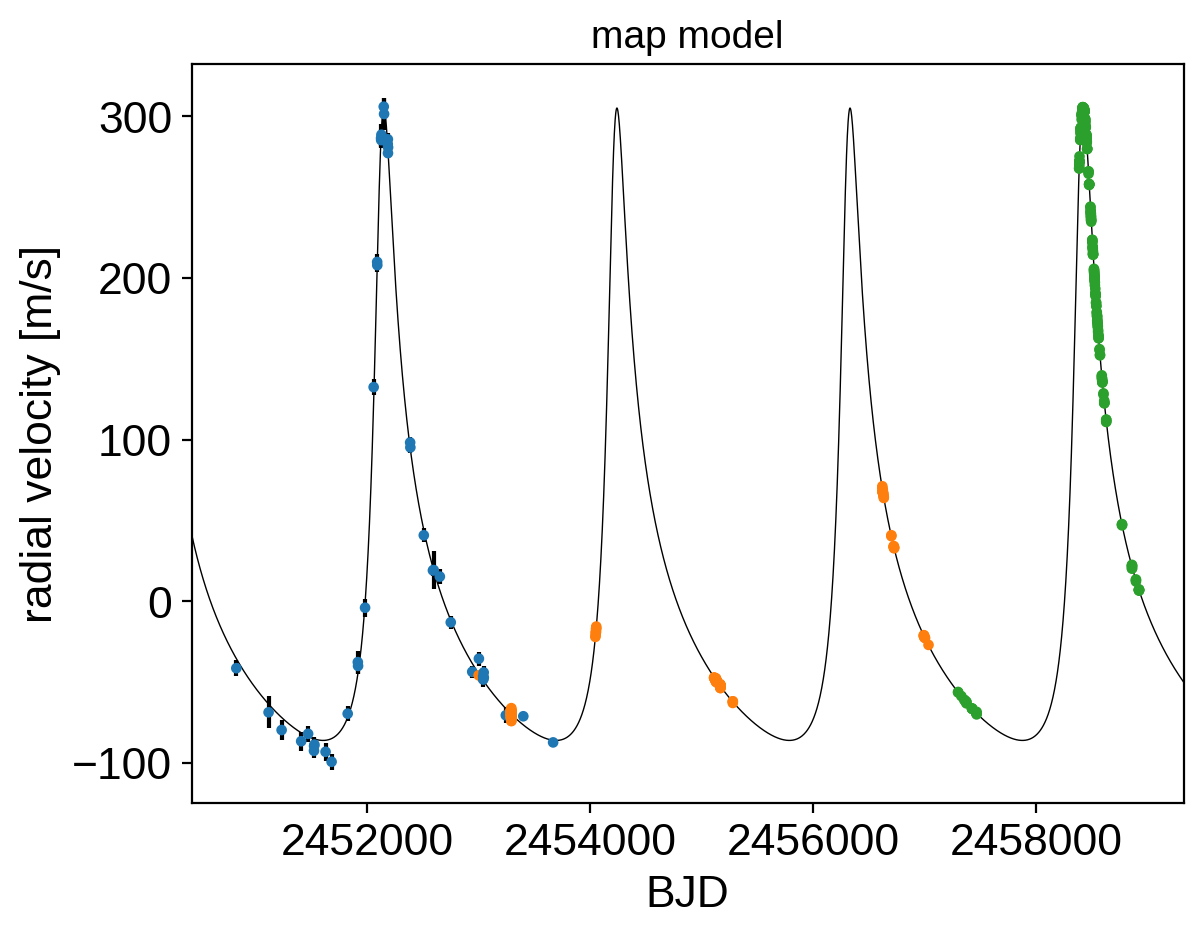

In [5]:
t_pred = np.linspace(t.min() - 400, t.max() + 400, 5000)
with model:
    plt.plot(t_pred, xo.eval_in_model(rv_model(t_pred), map_soln), "k", lw=0.5)

detrended = rv - map_soln["mean"] - map_soln["gp_pred"]
plt.errorbar(t, detrended, yerr=rv_err, fmt=",k")
plt.scatter(t, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10)
plt.xlim(t_pred.min(), t_pred.max())
plt.xlabel("BJD")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("map model", fontsize=14)

That looks fine, so now we can run the MCMC sampler:

In [6]:
np.random.seed(39091)
with model:
    trace = xo.sample(tune=3500, draws=3000, start=map_soln, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigmas, means, ell, S_tot, phase, ecs, P, K]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 17/26000 [00:00<04:21, 99.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/26000 [00:00<08:18, 52.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:00<10:45, 40.21draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:00<12:53, 33.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:00<14:07, 30.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:00<14:51, 29.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:01<15:24, 28.08draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:01<15:43, 27.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:01<16:02, 26.96draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/26000 [00:01<16:26, 26.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/26000 [00:01<18:08, 23.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/26000 [00:01<17:41, 24.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:02<17:28, 24.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:02<17:15, 25.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:02<17:05, 25.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/26000 [00:02<15:58, 27.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:02<16:11, 26.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:02<16:18, 26.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:03<16:22, 26.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 94/26000 [00:03<16:26, 26.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 98/26000 [00:03<16:38, 25.93draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:03<18:29, 23.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:03<17:52, 24.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 110/26000 [00:03<17:28, 24.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 114/26000 [00:04<17:19, 24.90draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:04<17:08, 25.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:04<16:59, 25.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:04<16:54, 25.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:04<16:46, 25.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:04<16:42, 25.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:04<16:50, 25.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:05<18:06, 23.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:05<18:47, 22.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:05<18:03, 23.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:05<17:32, 24.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:05<17:48, 24.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:05<17:37, 24.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:06<17:16, 24.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:06<17:08, 25.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/26000 [00:06<16:55, 25.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:06<16:47, 25.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:06<16:42, 25.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [00:06<16:38, 25.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [00:07<16:34, 25.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [00:07<15:35, 27.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [00:07<15:49, 27.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 205/26000 [00:07<14:23, 29.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [00:07<12:43, 33.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [00:07<13:12, 32.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 219/26000 [00:07<12:36, 34.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 224/26000 [00:07<11:35, 37.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [00:08<10:36, 40.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [00:08<09:10, 46.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [00:08<07:23, 58.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [00:08<06:07, 69.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [00:08<04:49, 88.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 304/26000 [00:08<04:18, 99.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 326/26000 [00:08<03:36, 118.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [00:08<02:59, 143.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [00:08<02:33, 166.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [00:09<02:12, 192.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [00:09<02:08, 199.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [00:09<01:49, 233.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 525/26000 [00:09<01:33, 273.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [00:09<01:20, 316.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 622/26000 [00:09<01:12, 349.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [00:09<01:09, 362.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [00:09<01:05, 385.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [00:09<01:02, 407.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [00:09<01:00, 415.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [00:10<00:57, 436.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 898/26000 [00:10<00:59, 421.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 942/26000 [00:10<01:01, 409.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 995/26000 [00:10<00:57, 438.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1043/26000 [00:10<00:55, 447.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [00:10<00:52, 470.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1146/26000 [00:10<00:52, 476.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [00:10<00:51, 480.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [00:10<00:53, 465.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1301/26000 [00:11<00:50, 491.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1359/26000 [00:11<00:48, 512.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1418/26000 [00:11<00:46, 531.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [00:11<00:44, 545.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1537/26000 [00:11<00:44, 551.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1593/26000 [00:11<00:44, 546.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1651/26000 [00:11<00:43, 555.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [00:11<00:44, 542.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1762/26000 [00:11<00:46, 523.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1815/26000 [00:11<00:46, 515.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [00:12<00:47, 505.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [00:12<00:47, 504.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1980/26000 [00:12<00:45, 532.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [00:12<00:44, 536.39draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2093/26000 [00:12<00:43, 545.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [00:12<00:43, 549.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2205/26000 [00:12<00:43, 544.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2260/26000 [00:12<00:44, 538.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [00:12<00:44, 538.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2368/26000 [00:12<00:45, 524.19draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [00:13<00:45, 515.51draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2474/26000 [00:13<00:45, 517.59draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2526/26000 [00:13<00:46, 503.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2577/26000 [00:13<00:47, 494.42draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [00:13<00:46, 500.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2686/26000 [00:13<00:45, 516.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2741/26000 [00:13<00:44, 524.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2794/26000 [00:13<00:47, 489.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [00:13<00:47, 483.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2893/26000 [00:14<00:47, 484.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2951/26000 [00:14<00:45, 506.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [00:14<00:47, 486.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3053/26000 [00:14<00:46, 488.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [00:14<00:45, 505.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3161/26000 [00:14<00:46, 491.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3211/26000 [00:14<00:48, 469.88draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3272/26000 [00:14<00:45, 504.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3324/26000 [00:14<00:52, 432.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3370/26000 [00:15<00:53, 426.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3415/26000 [00:15<00:57, 390.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3456/26000 [00:15<00:59, 379.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [00:15<01:01, 366.53draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3537/26000 [00:15<00:59, 375.09draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3580/26000 [00:15<00:57, 389.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [00:15<00:54, 412.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [00:15<00:51, 430.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3721/26000 [00:15<00:51, 431.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3766/26000 [00:16<00:51, 434.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [00:16<00:51, 433.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [00:16<00:50, 440.99draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3905/26000 [00:16<00:48, 454.39draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3951/26000 [00:16<00:49, 442.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3998/26000 [00:16<00:49, 440.86draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4043/26000 [00:16<00:50, 433.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [00:16<00:49, 438.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4140/26000 [00:16<00:48, 452.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4188/26000 [00:16<00:47, 459.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4237/26000 [00:17<00:46, 466.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4284/26000 [00:17<00:47, 457.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4337/26000 [00:17<00:45, 474.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4393/26000 [00:17<00:43, 496.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4449/26000 [00:17<00:41, 513.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4502/26000 [00:17<00:41, 516.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4554/26000 [00:17<00:42, 507.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [00:17<00:41, 515.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [00:17<00:41, 513.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [00:18<00:40, 523.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [00:18<00:40, 520.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4823/26000 [00:18<00:40, 527.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4879/26000 [00:18<00:39, 534.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [00:18<00:40, 515.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [00:18<00:40, 517.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5039/26000 [00:18<00:40, 518.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5094/26000 [00:18<00:39, 527.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5147/26000 [00:18<00:41, 504.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5198/26000 [00:18<00:41, 502.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5249/26000 [00:19<00:41, 499.85draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5300/26000 [00:19<00:42, 482.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5349/26000 [00:19<00:45, 456.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5396/26000 [00:19<00:45, 448.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5443/26000 [00:19<00:45, 452.77draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [00:19<00:46, 440.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [00:19<00:46, 442.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [00:19<00:45, 450.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5628/26000 [00:19<00:46, 442.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [00:20<00:44, 458.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5732/26000 [00:20<00:42, 477.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [00:20<00:42, 477.69draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5833/26000 [00:20<00:41, 489.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5883/26000 [00:20<00:40, 492.12draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5933/26000 [00:20<00:40, 492.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [00:20<00:39, 512.97draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6042/26000 [00:20<00:39, 511.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [00:20<00:41, 478.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6143/26000 [00:21<00:48, 413.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6187/26000 [00:21<00:51, 387.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6229/26000 [00:21<00:49, 395.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6270/26000 [00:21<00:52, 373.08draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6309/26000 [00:21<00:52, 377.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [00:21<00:50, 388.36draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6394/26000 [00:21<00:49, 397.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [00:21<00:49, 392.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [00:21<00:49, 392.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6518/26000 [00:21<00:48, 402.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [00:22<00:47, 407.19draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6601/26000 [00:22<00:48, 398.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6644/26000 [00:22<00:48, 401.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6686/26000 [00:22<00:47, 405.97draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6727/26000 [00:22<00:51, 370.92draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6774/26000 [00:22<00:48, 395.41draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6815/26000 [00:22<00:49, 388.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6861/26000 [00:22<00:47, 406.10draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6903/26000 [00:22<00:47, 405.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6949/26000 [00:23<00:45, 418.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [00:23<00:44, 426.41draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7038/26000 [00:23<00:44, 426.26draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7085/26000 [00:23<00:43, 436.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [00:23<00:43, 430.71draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7173/26000 [00:23<00:45, 416.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7216/26000 [00:23<00:44, 419.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [00:23<00:43, 427.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7307/26000 [00:23<00:43, 428.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [00:23<00:42, 436.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7399/26000 [00:24<00:46, 398.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7440/26000 [00:24<00:48, 383.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7484/26000 [00:24<00:47, 389.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [00:24<00:45, 405.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7571/26000 [00:24<00:46, 395.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [00:24<00:45, 407.65draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7660/26000 [00:24<00:44, 414.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7708/26000 [00:24<00:42, 432.11draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7752/26000 [00:24<00:42, 425.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [00:25<00:42, 428.47draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [00:25<00:42, 430.00draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7885/26000 [00:25<00:44, 409.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7927/26000 [00:25<00:45, 400.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [00:25<00:45, 398.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [00:25<00:44, 402.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8051/26000 [00:25<00:44, 403.41draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [00:25<00:43, 416.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8149/26000 [00:25<00:40, 443.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8196/26000 [00:26<00:39, 449.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8243/26000 [00:26<00:39, 453.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8290/26000 [00:26<00:39, 452.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [00:26<00:41, 425.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [00:26<00:41, 421.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8424/26000 [00:26<00:41, 424.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8467/26000 [00:26<00:42, 415.08draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [00:26<00:41, 424.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [00:26<00:40, 431.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8603/26000 [00:26<00:39, 436.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [00:27<00:40, 425.29draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [00:27<00:40, 431.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8740/26000 [00:27<00:39, 442.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [00:27<00:38, 443.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [00:27<00:41, 418.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [00:27<00:40, 422.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8917/26000 [00:27<00:40, 420.00draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8963/26000 [00:27<00:39, 426.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [00:27<00:39, 427.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9049/26000 [00:28<00:40, 413.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9100/26000 [00:28<00:38, 434.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9147/26000 [00:28<00:38, 441.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9192/26000 [00:28<00:37, 443.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9239/26000 [00:28<00:37, 448.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9285/26000 [00:28<00:37, 450.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9331/26000 [00:28<00:37, 440.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [00:28<00:37, 443.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [00:28<00:37, 444.52draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9468/26000 [00:28<00:37, 445.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [00:29<00:36, 456.19draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9566/26000 [00:29<00:35, 462.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [00:29<00:36, 444.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9660/26000 [00:29<00:36, 450.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [00:29<00:37, 433.42draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9750/26000 [00:29<00:38, 417.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [00:29<00:38, 426.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9845/26000 [00:29<00:36, 443.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [00:29<00:38, 423.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9934/26000 [00:30<00:37, 428.36draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9983/26000 [00:30<00:36, 444.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10028/26000 [00:30<00:36, 438.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [00:30<00:35, 446.60draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10120/26000 [00:30<00:36, 436.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [00:30<00:36, 434.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10208/26000 [00:30<00:37, 423.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [00:30<00:37, 422.53draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10294/26000 [00:30<00:37, 423.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10337/26000 [00:30<00:38, 410.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10379/26000 [00:31<00:37, 412.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10423/26000 [00:31<00:37, 416.81draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10465/26000 [00:31<00:37, 417.72draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [00:31<00:36, 420.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [00:31<00:36, 423.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [00:31<00:35, 439.87draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [00:31<00:36, 423.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10698/26000 [00:31<00:34, 441.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [00:31<00:34, 445.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10793/26000 [00:31<00:33, 455.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [00:32<00:34, 445.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10884/26000 [00:32<00:34, 442.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [00:32<00:33, 446.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10977/26000 [00:32<00:33, 446.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11022/26000 [00:32<00:35, 426.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11065/26000 [00:32<00:36, 412.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11107/26000 [00:32<00:36, 406.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11150/26000 [00:32<00:36, 408.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [00:32<00:34, 431.80draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11249/26000 [00:33<00:33, 444.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11294/26000 [00:33<00:33, 440.36draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [00:33<00:32, 451.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11389/26000 [00:33<00:33, 441.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11434/26000 [00:33<00:33, 440.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11480/26000 [00:33<00:32, 442.60draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11529/26000 [00:33<00:32, 451.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11577/26000 [00:33<00:31, 457.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [00:33<00:30, 475.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11678/26000 [00:33<00:31, 459.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11725/26000 [00:34<00:31, 450.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11771/26000 [00:34<00:31, 451.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11817/26000 [00:34<00:32, 434.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11861/26000 [00:34<00:33, 422.54draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11904/26000 [00:34<00:33, 418.22draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11949/26000 [00:34<00:32, 426.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11994/26000 [00:34<00:32, 429.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [00:34<00:32, 435.07draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12085/26000 [00:34<00:31, 439.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12129/26000 [00:35<00:33, 413.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12171/26000 [00:35<00:33, 411.67draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [00:35<00:32, 422.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12259/26000 [00:35<00:32, 423.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12307/26000 [00:35<00:31, 438.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12352/26000 [00:35<00:31, 431.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12396/26000 [00:35<00:31, 426.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12442/26000 [00:35<00:31, 432.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [00:35<00:31, 434.93draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12530/26000 [00:35<00:31, 432.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12574/26000 [00:36<00:31, 421.16draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [00:36<00:32, 416.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12666/26000 [00:36<00:30, 434.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [00:36<00:30, 434.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [00:36<00:30, 428.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [00:36<00:30, 430.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [00:36<00:30, 429.82draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [00:36<00:31, 415.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12928/26000 [00:36<00:32, 403.40draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12971/26000 [00:37<00:32, 406.31draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13014/26000 [00:37<00:31, 412.84draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13062/26000 [00:37<00:30, 426.58draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13107/26000 [00:37<00:29, 431.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13155/26000 [00:37<00:29, 441.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13200/26000 [00:37<00:30, 420.17draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [00:37<00:33, 380.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13282/26000 [00:37<00:34, 369.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [00:37<00:34, 371.81draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [00:38<00:32, 393.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13408/26000 [00:38<00:32, 388.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13448/26000 [00:38<00:32, 387.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13490/26000 [00:38<00:31, 397.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13534/26000 [00:38<00:30, 408.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13576/26000 [00:38<00:30, 411.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13618/26000 [00:38<00:32, 378.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13657/26000 [00:38<00:33, 367.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13703/26000 [00:38<00:31, 388.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [00:38<00:30, 396.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13786/26000 [00:39<00:31, 392.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13829/26000 [00:39<00:30, 402.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13870/26000 [00:39<00:31, 383.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13909/26000 [00:39<00:31, 379.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13950/26000 [00:39<00:31, 383.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [00:39<00:31, 376.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14033/26000 [00:39<00:30, 391.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14074/26000 [00:39<00:30, 393.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [00:39<00:29, 401.77draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14160/26000 [00:40<00:28, 408.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14202/26000 [00:40<00:30, 388.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [00:40<00:30, 383.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14284/26000 [00:40<00:29, 393.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14324/26000 [00:40<00:29, 391.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14364/26000 [00:40<00:31, 367.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14402/26000 [00:40<00:31, 362.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14439/26000 [00:40<00:34, 330.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14475/26000 [00:40<00:34, 337.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14512/26000 [00:41<00:33, 346.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [00:41<00:33, 346.48draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [00:41<00:31, 365.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [00:41<00:31, 355.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14664/26000 [00:41<00:33, 343.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14701/26000 [00:41<00:32, 346.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [00:41<00:32, 342.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14771/26000 [00:41<00:32, 342.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [00:41<00:30, 361.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14851/26000 [00:41<00:30, 362.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14888/26000 [00:42<00:30, 360.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14925/26000 [00:42<00:30, 357.92draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 14961/26000 [00:42<00:30, 357.37draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15000/26000 [00:42<00:30, 363.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15037/26000 [00:42<00:31, 346.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15073/26000 [00:42<00:31, 348.21draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15108/26000 [00:42<00:31, 344.75draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15144/26000 [00:42<00:31, 348.67draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 15180/26000 [00:42<00:30, 350.18draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15216/26000 [00:43<00:30, 352.27draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 15252/26000 [00:43<00:30, 354.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15288/26000 [00:43<00:30, 350.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15324/26000 [00:43<00:31, 344.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15359/26000 [00:43<00:31, 341.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15394/26000 [00:43<00:30, 342.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15433/26000 [00:43<00:29, 355.31draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 15469/26000 [00:43<00:29, 354.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15505/26000 [00:43<00:30, 345.98draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15540/26000 [00:43<00:31, 336.48draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 15574/26000 [00:44<00:31, 332.53draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15608/26000 [00:44<00:31, 332.22draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15645/26000 [00:44<00:30, 342.24draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15683/26000 [00:44<00:29, 350.34draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 15719/26000 [00:44<00:29, 352.74draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15758/26000 [00:44<00:28, 362.40draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15796/26000 [00:44<00:28, 363.95draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15835/26000 [00:44<00:27, 365.36draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15873/26000 [00:44<00:27, 364.77draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 15910/26000 [00:44<00:27, 361.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 15952/26000 [00:45<00:27, 371.15draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 15991/26000 [00:45<00:26, 373.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16030/26000 [00:45<00:26, 377.17draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16068/26000 [00:45<00:27, 357.95draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16105/26000 [00:45<00:28, 348.22draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16142/26000 [00:45<00:28, 348.82draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16178/26000 [00:45<00:27, 350.81draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 16216/26000 [00:45<00:27, 353.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16252/26000 [00:45<00:27, 350.95draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16288/26000 [00:46<00:27, 350.94draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16324/26000 [00:46<00:27, 351.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16363/26000 [00:46<00:26, 361.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16400/26000 [00:46<00:27, 353.43draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16438/26000 [00:46<00:26, 360.11draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 16475/26000 [00:46<00:26, 355.22draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16511/26000 [00:46<00:27, 344.73draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 16546/26000 [00:46<00:28, 336.94draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16580/26000 [00:46<00:28, 331.59draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16614/26000 [00:47<00:28, 331.18draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16648/26000 [00:47<00:28, 333.24draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16685/26000 [00:47<00:27, 342.79draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16720/26000 [00:47<00:27, 337.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 16756/26000 [00:47<00:27, 342.22draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16793/26000 [00:47<00:26, 348.62draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16831/26000 [00:47<00:25, 356.90draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 16869/26000 [00:47<00:25, 361.12draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16907/26000 [00:47<00:24, 365.68draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16945/26000 [00:47<00:24, 366.25draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 16983/26000 [00:48<00:24, 365.69draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 17024/26000 [00:48<00:24, 373.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17062/26000 [00:48<00:23, 372.60draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17100/26000 [00:48<00:23, 371.55draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17139/26000 [00:48<00:23, 375.30draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17177/26000 [00:48<00:24, 366.08draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 17214/26000 [00:48<00:24, 365.94draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17251/26000 [00:48<00:24, 361.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 17288/26000 [00:48<00:24, 356.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17324/26000 [00:48<00:25, 345.95draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17359/26000 [00:49<00:25, 339.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17394/26000 [00:49<00:25, 338.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17430/26000 [00:49<00:24, 344.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17468/26000 [00:49<00:24, 352.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17504/26000 [00:49<00:23, 354.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 17540/26000 [00:49<00:23, 354.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17576/26000 [00:49<00:23, 351.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17612/26000 [00:49<00:23, 351.67draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17648/26000 [00:49<00:23, 352.22draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17684/26000 [00:50<00:24, 346.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17721/26000 [00:50<00:23, 352.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17757/26000 [00:50<00:23, 354.71draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 17793/26000 [00:50<00:23, 346.38draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17829/26000 [00:50<00:23, 348.09draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 17871/26000 [00:50<00:22, 366.84draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17908/26000 [00:50<00:22, 364.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17945/26000 [00:50<00:22, 363.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 17982/26000 [00:50<00:21, 364.49draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18019/26000 [00:50<00:22, 350.81draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 18056/26000 [00:51<00:22, 356.23draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18092/26000 [00:51<00:22, 352.40draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18128/26000 [00:51<00:22, 353.89draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 18164/26000 [00:51<00:22, 344.84draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18203/26000 [00:51<00:22, 353.27draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18239/26000 [00:51<00:22, 348.26draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18276/26000 [00:51<00:22, 350.93draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 18312/26000 [00:51<00:21, 352.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18348/26000 [00:51<00:22, 347.21draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18385/26000 [00:51<00:21, 353.07draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18422/26000 [00:52<00:21, 353.05draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18459/26000 [00:52<00:21, 352.78draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 18495/26000 [00:52<00:21, 350.30draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18532/26000 [00:52<00:21, 354.90draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 18568/26000 [00:52<00:21, 352.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18608/26000 [00:52<00:20, 365.00draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18646/26000 [00:52<00:20, 366.28draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18683/26000 [00:52<00:20, 362.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18723/26000 [00:52<00:19, 372.34draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18761/26000 [00:53<00:19, 365.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18798/26000 [00:53<00:19, 363.05draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 18835/26000 [00:53<00:19, 363.47draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18872/26000 [00:53<00:19, 359.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18910/26000 [00:53<00:19, 363.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18947/26000 [00:53<00:19, 358.18draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 18985/26000 [00:53<00:19, 363.92draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19026/26000 [00:53<00:18, 372.96draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19065/26000 [00:53<00:18, 377.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 19103/26000 [00:53<00:19, 360.54draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 19140/26000 [00:54<00:19, 355.07draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19176/26000 [00:54<00:19, 347.83draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19211/26000 [00:54<00:19, 344.02draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19249/26000 [00:54<00:19, 349.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19287/26000 [00:54<00:18, 357.05draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19324/26000 [00:54<00:18, 358.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 19362/26000 [00:54<00:18, 361.99draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19399/26000 [00:54<00:18, 355.46draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19435/26000 [00:54<00:18, 352.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 19471/26000 [00:55<00:18, 349.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19509/26000 [00:55<00:18, 358.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19545/26000 [00:55<00:18, 355.82draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19583/26000 [00:55<00:17, 362.35draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 19623/26000 [00:55<00:17, 371.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19661/26000 [00:55<00:17, 362.98draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19698/26000 [00:55<00:17, 360.69draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19735/26000 [00:55<00:17, 355.49draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19773/26000 [00:55<00:17, 362.00draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 19810/26000 [00:55<00:17, 360.82draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19847/26000 [00:56<00:17, 360.50draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 19884/26000 [00:56<00:16, 360.11draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19921/26000 [00:56<00:17, 350.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19957/26000 [00:56<00:17, 343.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 19992/26000 [00:56<00:17, 341.46draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20027/26000 [00:56<00:17, 335.19draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20064/26000 [00:56<00:17, 343.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20099/26000 [00:56<00:17, 344.98draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 20134/26000 [00:56<00:17, 343.81draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20169/26000 [00:56<00:17, 342.85draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20207/26000 [00:57<00:16, 345.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20246/26000 [00:57<00:16, 355.02draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20282/26000 [00:57<00:16, 348.14draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20317/26000 [00:57<00:16, 344.40draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20353/26000 [00:57<00:16, 346.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 20390/26000 [00:57<00:15, 352.51draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20426/26000 [00:57<00:15, 350.05draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 20464/26000 [00:57<00:15, 353.61draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20500/26000 [00:57<00:15, 348.14draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20535/26000 [00:58<00:15, 347.68draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20570/26000 [00:58<00:15, 342.50draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20607/26000 [00:58<00:15, 350.12draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 20643/26000 [00:58<00:15, 351.21draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20683/26000 [00:58<00:14, 362.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20721/26000 [00:58<00:14, 365.52draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20758/26000 [00:58<00:14, 354.38draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 20794/26000 [00:58<00:14, 352.96draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20830/26000 [00:58<00:14, 350.49draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20866/26000 [00:58<00:14, 349.91draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 20902/26000 [00:59<00:14, 352.34draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20938/26000 [00:59<00:14, 344.75draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 20973/26000 [00:59<00:15, 333.73draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21007/26000 [00:59<00:14, 335.50draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21044/26000 [00:59<00:14, 345.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21082/26000 [00:59<00:14, 347.44draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 21117/26000 [00:59<00:14, 341.91draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 21154/26000 [00:59<00:13, 349.10draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21190/26000 [00:59<00:13, 351.19draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21226/26000 [01:00<00:13, 345.37draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21261/26000 [01:00<00:14, 336.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21295/26000 [01:00<00:14, 329.99draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21330/26000 [01:00<00:13, 335.09draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21365/26000 [01:00<00:13, 336.07draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21402/26000 [01:00<00:13, 342.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 21440/26000 [01:00<00:13, 349.90draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21476/26000 [01:00<00:12, 351.76draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21516/26000 [01:00<00:12, 359.99draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21553/26000 [01:00<00:12, 348.59draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21589/26000 [01:01<00:13, 333.00draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21623/26000 [01:01<00:13, 331.81draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21657/26000 [01:01<00:13, 330.67draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 21692/26000 [01:01<00:12, 333.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21727/26000 [01:01<00:12, 335.28draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 21765/26000 [01:01<00:12, 340.39draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21803/26000 [01:01<00:12, 348.73draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21838/26000 [01:01<00:12, 340.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21873/26000 [01:01<00:12, 342.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21908/26000 [01:02<00:12, 340.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 21949/26000 [01:02<00:11, 355.71draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 21986/26000 [01:02<00:11, 356.26draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22022/26000 [01:02<00:11, 357.37draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22058/26000 [01:02<00:11, 352.65draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 22095/26000 [01:02<00:10, 357.02draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22131/26000 [01:02<00:10, 357.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22169/26000 [01:02<00:10, 361.43draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 22206/26000 [01:02<00:10, 355.39draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22243/26000 [01:02<00:10, 357.19draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22279/26000 [01:03<00:10, 355.68draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22315/26000 [01:03<00:10, 356.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22351/26000 [01:03<00:10, 348.92draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22386/26000 [01:03<00:10, 341.12draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 22422/26000 [01:03<00:10, 345.81draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 22457/26000 [01:03<00:10, 344.41draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22492/26000 [01:03<00:10, 343.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22527/26000 [01:03<00:10, 343.09draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22565/26000 [01:03<00:09, 352.85draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22601/26000 [01:03<00:09, 344.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22636/26000 [01:04<00:09, 344.32draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22674/26000 [01:04<00:09, 352.37draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22710/26000 [01:04<00:09, 347.90draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 22745/26000 [01:04<00:09, 348.50draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22780/26000 [01:04<00:09, 345.43draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22815/26000 [01:04<00:09, 343.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22850/26000 [01:04<00:09, 344.84draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22886/26000 [01:04<00:08, 346.22draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22921/26000 [01:04<00:08, 344.20draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22960/26000 [01:05<00:08, 356.55draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 22996/26000 [01:05<00:08, 354.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23034/26000 [01:05<00:08, 359.79draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 23071/26000 [01:05<00:08, 360.99draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23108/26000 [01:05<00:08, 361.33draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23145/26000 [01:05<00:07, 358.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23181/26000 [01:05<00:07, 353.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23219/26000 [01:05<00:07, 359.41draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 23260/26000 [01:05<00:07, 370.68draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23298/26000 [01:05<00:07, 368.17draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23335/26000 [01:06<00:07, 353.92draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 23375/26000 [01:06<00:07, 364.56draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23412/26000 [01:06<00:07, 359.11draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23449/26000 [01:06<00:07, 338.02draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23484/26000 [01:06<00:07, 337.64draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 23521/26000 [01:06<00:07, 338.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23556/26000 [01:06<00:07, 327.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23591/26000 [01:06<00:07, 331.48draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23625/26000 [01:06<00:07, 324.29draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23663/26000 [01:07<00:06, 337.21draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 23698/26000 [01:07<00:06, 339.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23737/26000 [01:07<00:06, 352.07draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 23775/26000 [01:07<00:06, 359.97draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23812/26000 [01:07<00:06, 359.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23849/26000 [01:07<00:05, 360.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23886/26000 [01:07<00:05, 359.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23923/26000 [01:07<00:05, 349.11draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23959/26000 [01:07<00:05, 349.79draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 23995/26000 [01:07<00:06, 327.51draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 24029/26000 [01:08<00:06, 290.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24060/26000 [01:08<00:07, 274.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24089/26000 [01:08<00:07, 267.54draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24117/26000 [01:08<00:06, 270.99draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24145/26000 [01:08<00:06, 271.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24175/26000 [01:08<00:06, 276.16draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24204/26000 [01:08<00:06, 274.41draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24234/26000 [01:08<00:06, 280.39draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24263/26000 [01:08<00:06, 269.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 24291/26000 [01:09<00:06, 260.68draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24318/26000 [01:09<00:06, 260.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24345/26000 [01:09<00:06, 262.37draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 24372/26000 [01:09<00:06, 257.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24400/26000 [01:09<00:06, 262.06draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24427/26000 [01:09<00:06, 258.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24456/26000 [01:09<00:05, 264.04draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24484/26000 [01:09<00:05, 267.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24511/26000 [01:09<00:05, 257.93draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24537/26000 [01:10<00:05, 250.89draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 24563/26000 [01:10<00:05, 253.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24589/26000 [01:10<00:05, 255.30draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24615/26000 [01:10<00:05, 249.94draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24641/26000 [01:10<00:05, 243.41draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24669/26000 [01:10<00:05, 249.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 24696/26000 [01:10<00:05, 253.07draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24723/26000 [01:10<00:04, 256.98draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24749/26000 [01:10<00:04, 253.40draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24775/26000 [01:11<00:04, 251.84draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24801/26000 [01:11<00:04, 246.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 24827/26000 [01:11<00:04, 248.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24853/26000 [01:11<00:04, 248.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24880/26000 [01:11<00:04, 248.33draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24908/26000 [01:11<00:04, 256.65draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24934/26000 [01:11<00:04, 252.79draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24960/26000 [01:11<00:04, 248.07draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 24987/26000 [01:11<00:04, 251.71draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 25013/26000 [01:11<00:03, 251.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25039/26000 [01:12<00:03, 245.02draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 25064/26000 [01:12<00:03, 244.65draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25093/26000 [01:12<00:03, 256.38draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25123/26000 [01:12<00:03, 261.70draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25150/26000 [01:12<00:03, 262.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25178/26000 [01:12<00:03, 267.21draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25205/26000 [01:12<00:02, 265.19draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25236/26000 [01:12<00:02, 275.12draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25264/26000 [01:12<00:02, 276.45draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25293/26000 [01:12<00:02, 276.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25321/26000 [01:13<00:02, 274.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 25349/26000 [01:13<00:02, 271.22draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25377/26000 [01:13<00:02, 268.60draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25404/26000 [01:13<00:02, 256.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25431/26000 [01:13<00:02, 259.40draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25458/26000 [01:13<00:02, 260.58draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25485/26000 [01:13<00:02, 252.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25512/26000 [01:13<00:01, 255.42draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25540/26000 [01:13<00:01, 262.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25567/26000 [01:14<00:01, 262.48draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 25595/26000 [01:14<00:01, 267.27draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25622/26000 [01:14<00:01, 264.85draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25649/26000 [01:14<00:01, 241.01draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 25674/26000 [01:14<00:01, 231.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25698/26000 [01:14<00:01, 221.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25721/26000 [01:14<00:01, 203.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25742/26000 [01:14<00:01, 190.75draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25762/26000 [01:15<00:01, 183.11draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25781/26000 [01:15<00:01, 174.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25799/26000 [01:15<00:01, 169.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25818/26000 [01:15<00:01, 172.39draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25839/26000 [01:15<00:00, 177.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 25857/26000 [01:15<00:00, 174.94draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25877/26000 [01:15<00:00, 180.95draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25896/26000 [01:15<00:00, 162.57draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25913/26000 [01:15<00:00, 134.24draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25928/26000 [01:16<00:00, 110.49draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25941/26000 [01:16<00:00, 106.59draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25953/26000 [01:16<00:00, 101.05draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25964/26000 [01:16<00:00, 92.19draws/s] 

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25974/26000 [01:16<00:00, 87.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25984/26000 [01:16<00:00, 87.90draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 25994/26000 [01:16<00:00, 79.70draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 26000/26000 [01:17<00:00, 337.27draws/s]

Then we can look at some summaries of the trace and the constraints on some of the key parameters:

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,2089.116,0.469,2088.250,2090.009,0.004,0.002,17573.0,17573.0,17624.0,8756.0,1.0
K,195.693,0.620,194.526,196.843,0.005,0.003,16656.0,16650.0,16665.0,8997.0,1.0
tp,2456300.672,0.784,2456299.179,2456302.128,0.006,0.004,16779.0,16779.0,16788.0,8497.0,1.0
ecc,0.644,0.002,0.640,0.648,0.000,0.000,16895.0,16895.0,16975.0,8431.0,1.0
omega,-0.519,0.006,-0.530,-0.508,0.000,0.000,17202.0,17202.0,17181.0,8596.0,1.0
means[0],1.779,1.038,-0.190,3.728,0.008,0.006,17485.0,13359.0,17499.0,8418.0,1.0
means[1],10709.375,0.531,10708.323,10710.325,0.004,0.003,17390.0,17390.0,17425.0,8005.0,1.0
means[2],10729.159,0.681,10727.890,10730.457,0.005,0.004,18289.0,18289.0,18274.0,9179.0,1.0
sigmas[0],3.022,1.420,0.032,5.219,0.018,0.013,6323.0,6323.0,5844.0,3482.0,1.0
sigmas[1],0.877,0.109,0.684,1.093,0.001,0.001,17362.0,16324.0,17823.0,8740.0,1.0


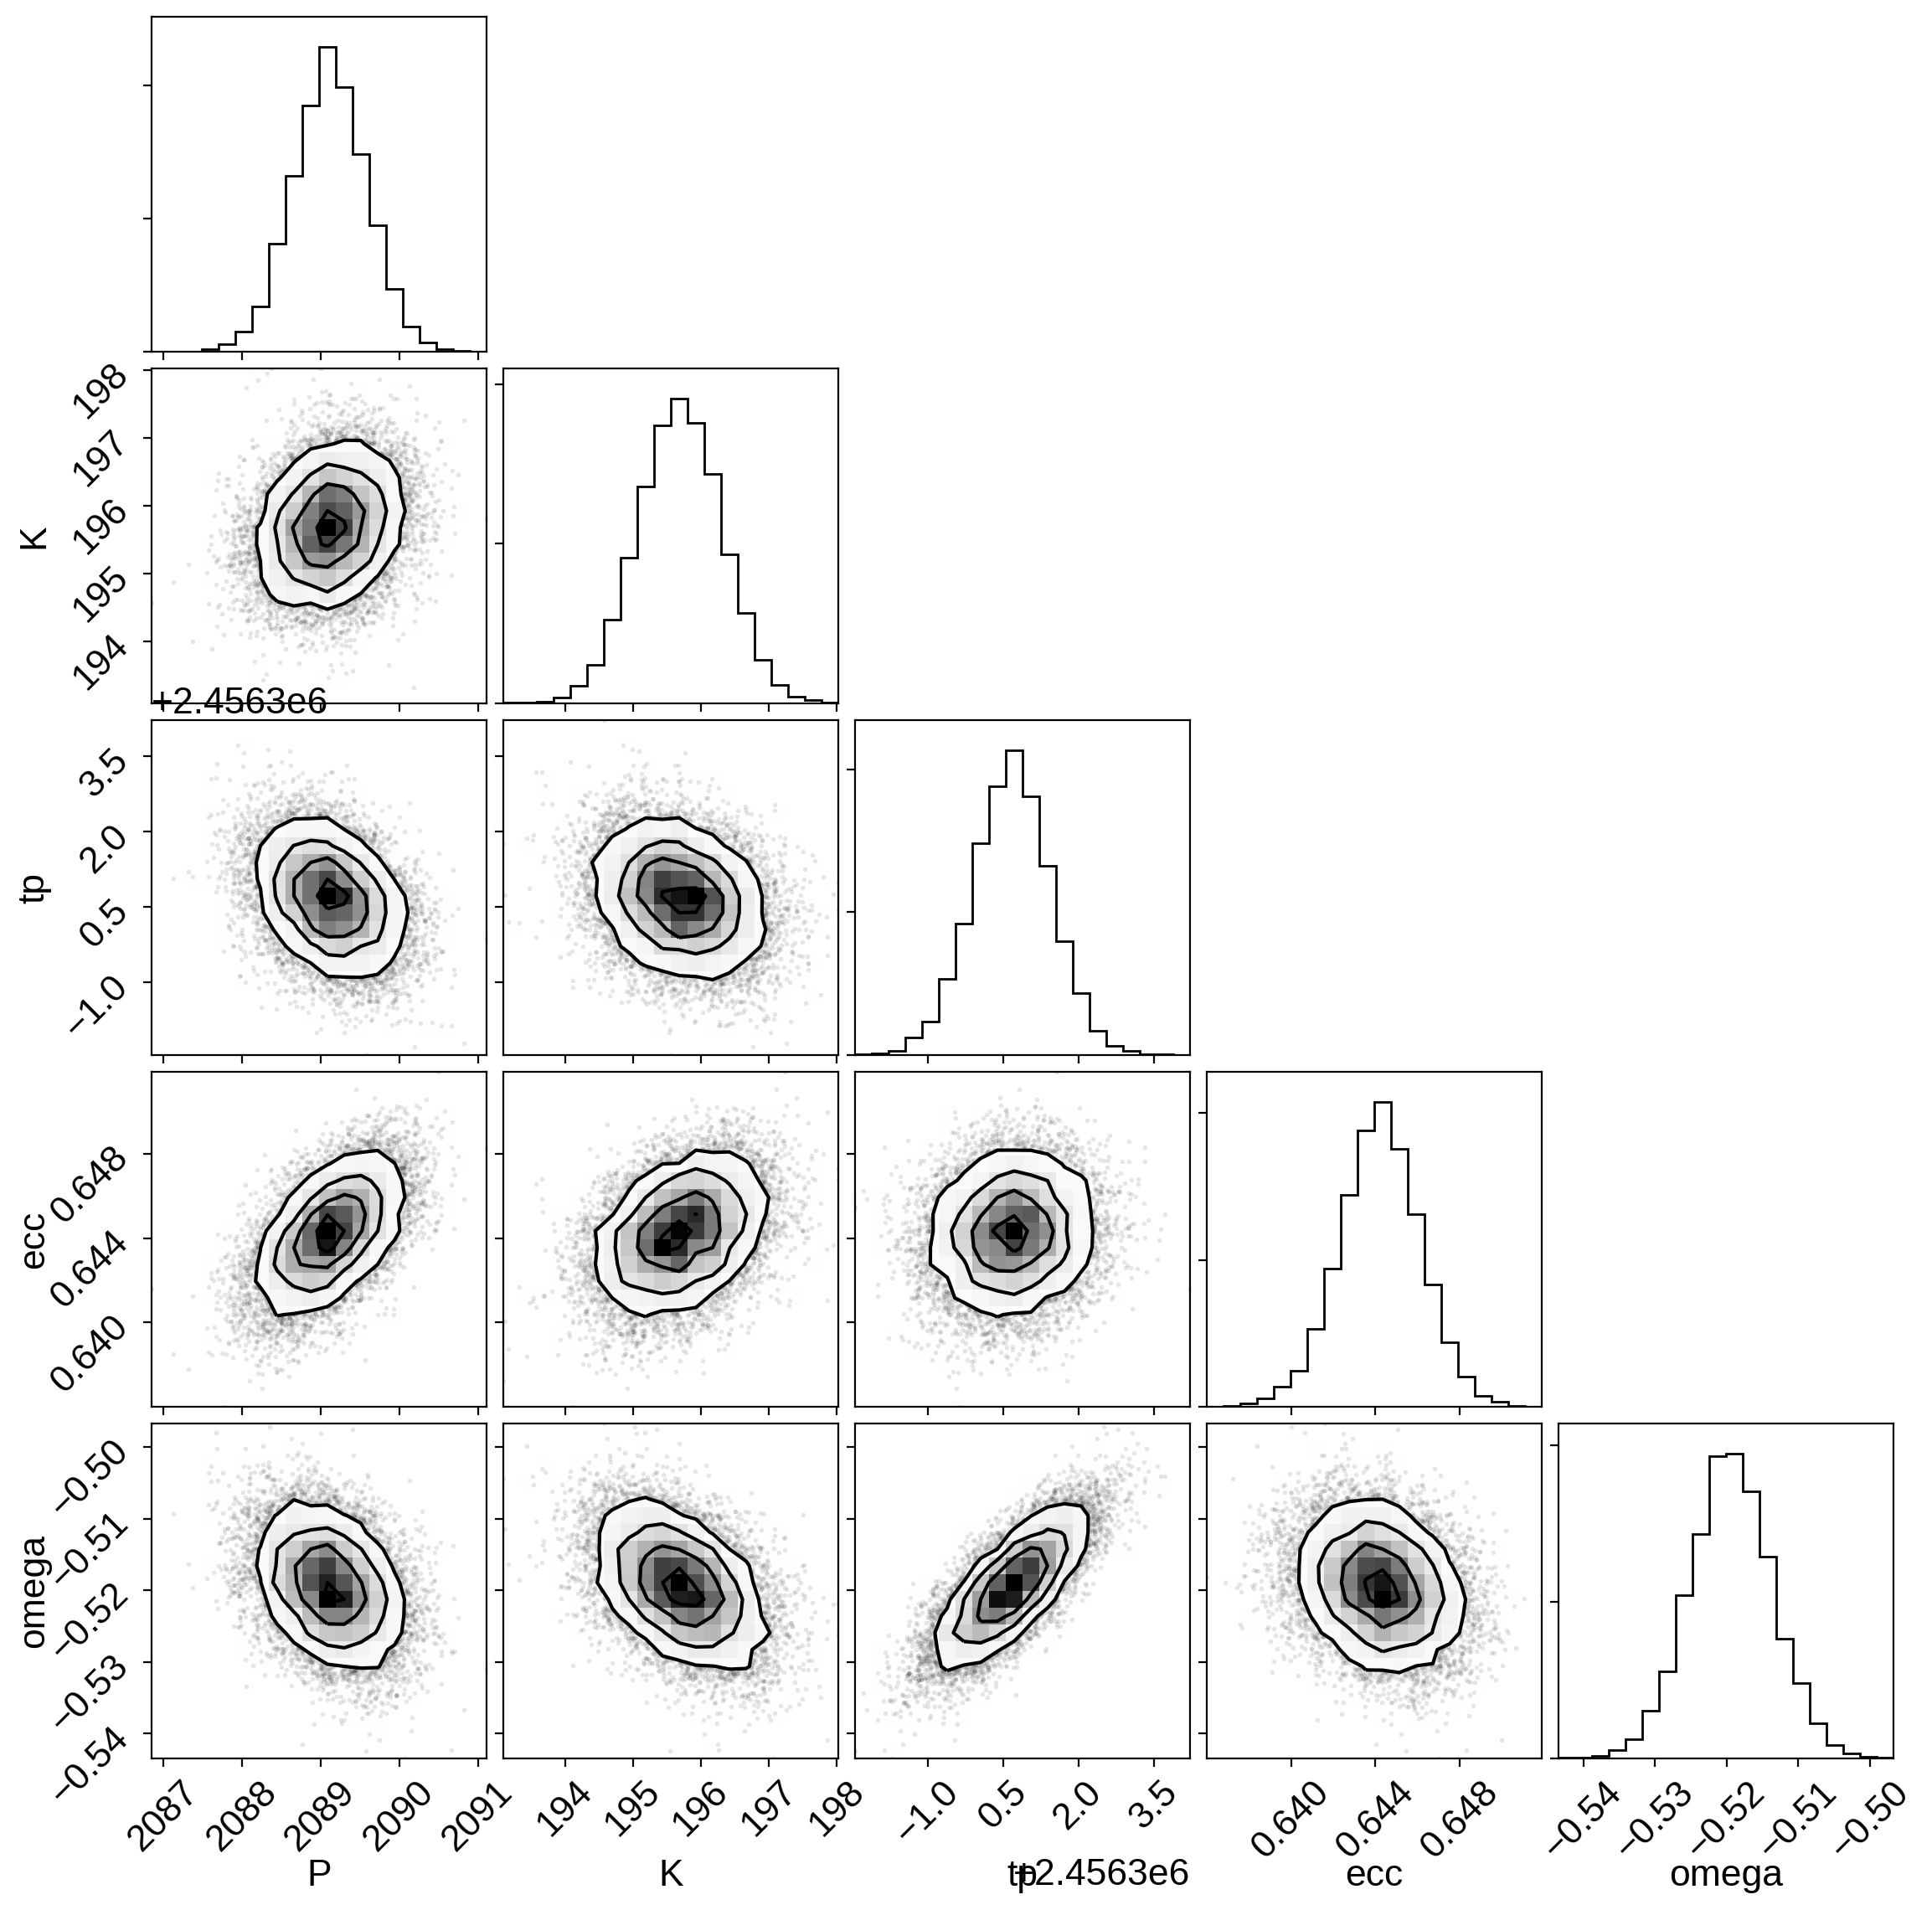

In [7]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["P", "K", "tp", "ecc", "omega"]))

pm.summary(trace, var_names=["P", "K", "tp", "ecc", "omega", "means", "sigmas"])

And finally we can plot the phased RV curve and overplot our posterior inference:

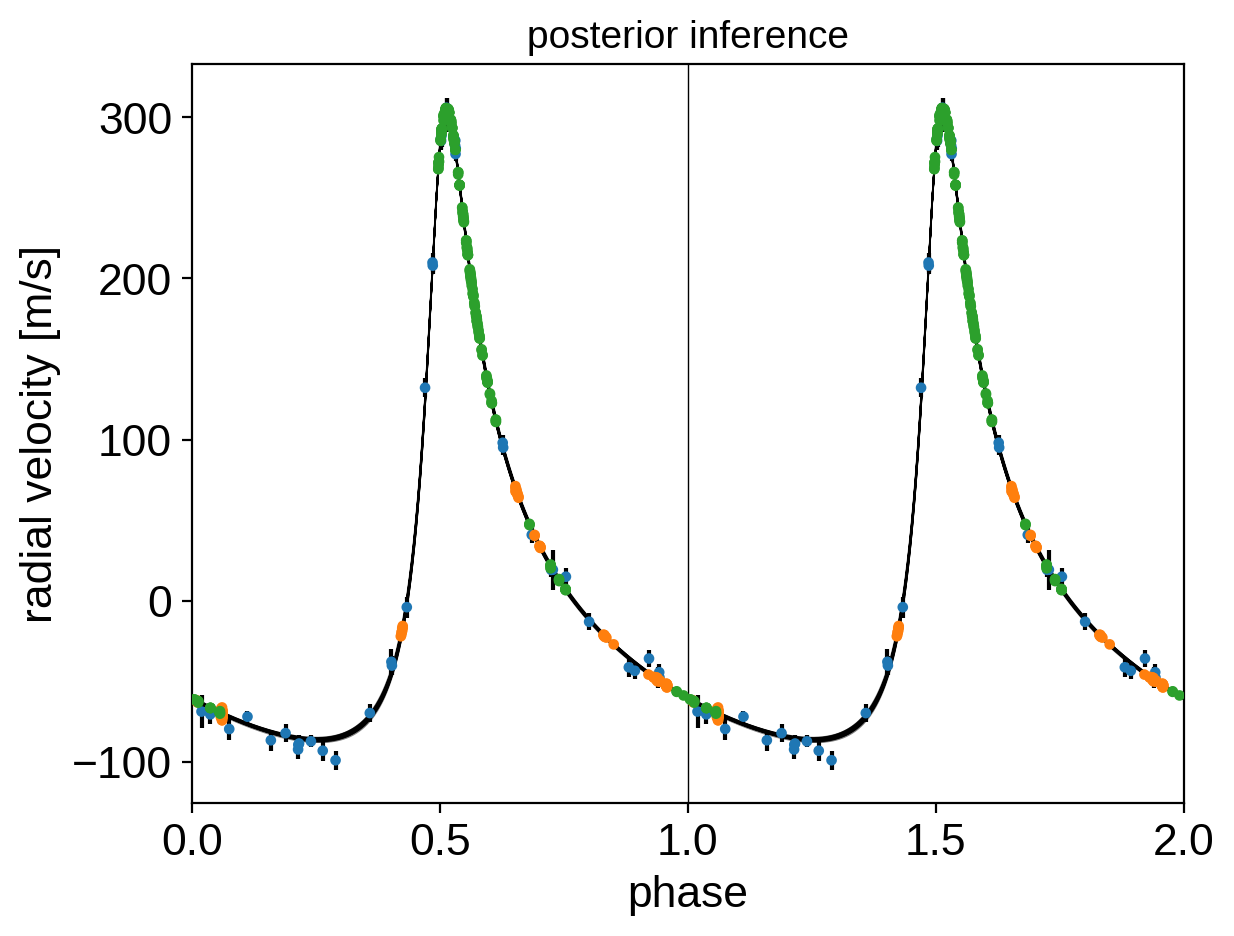

In [8]:
mu = np.mean(trace["mean"] + trace["gp_pred"], axis=0)
mu_var = np.var(trace["mean"], axis=0)
jitter_var = np.median(trace["diag"], axis=0)
period = np.median(trace["P"])
tp = np.median(trace["tp"])

detrended = rv - mu
folded = ((t - tp + 0.5 * period) % period) / period
plt.errorbar(folded, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k")
plt.scatter(
    folded, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10
)
plt.errorbar(folded + 1, detrended, yerr=np.sqrt(mu_var + jitter_var), fmt=",k")
plt.scatter(
    folded + 1, detrended, c=inst_id, s=8, zorder=100, cmap="tab10", vmin=0, vmax=10
)

t_phase = np.linspace(-0.5, 0.5, 5000)
with model:
    func = xo.get_theano_function_for_var(rv_model(model.P * t_phase + model.tp))
    for point in xo.get_samples_from_trace(trace, 100):
        args = xo.get_args_for_theano_function(point)
        x, y = t_phase + 0.5, func(*args)
        plt.plot(x, y, "k", lw=0.5, alpha=0.5)
        plt.plot(x + 1, y, "k", lw=0.5, alpha=0.5)
plt.axvline(1, color="k", lw=0.5)
plt.xlim(0, 2)
plt.xlabel("phase")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior inference", fontsize=14)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [9]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:pymc3, exoplanet:theano}.


In [10]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
